In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import scipy
import seaborn as sns

In [2]:
df_2015 = pd.read_csv('2015.csv')
df_2016 = pd.read_csv('2016.csv')
frames = [df_2015, df_2016]
df = pd.concat(frames)

In [3]:
print('Number of Features: ', len(df.columns))
print('Number of Observations: ', len(df))

Number of Features:  46
Number of Observations:  752559


In [4]:
df.columns

Index(['DEPARTURES_SCHEDULED', 'DEPARTURES_PERFORMED', 'PAYLOAD', 'SEATS',
       'PASSENGERS', 'FREIGHT', 'MAIL', 'DISTANCE', 'RAMP_TO_RAMP', 'AIR_TIME',
       'UNIQUE_CARRIER', 'AIRLINE_ID', 'UNIQUE_CARRIER_NAME',
       'UNIQUE_CARRIER_ENTITY', 'REGION', 'CARRIER', 'CARRIER_NAME',
       'CARRIER_GROUP', 'CARRIER_GROUP_NEW', 'ORIGIN_AIRPORT_ID',
       'ORIGIN_AIRPORT_SEQ_ID', 'ORIGIN_CITY_MARKET_ID', 'ORIGIN',
       'ORIGIN_CITY_NAME', 'ORIGIN_STATE_ABR', 'ORIGIN_STATE_FIPS',
       'ORIGIN_STATE_NM', 'ORIGIN_WAC', 'DEST_AIRPORT_ID',
       'DEST_AIRPORT_SEQ_ID', 'DEST_CITY_MARKET_ID', 'DEST', 'DEST_CITY_NAME',
       'DEST_STATE_ABR', 'DEST_STATE_FIPS', 'DEST_STATE_NM', 'DEST_WAC',
       'AIRCRAFT_GROUP', 'AIRCRAFT_TYPE', 'AIRCRAFT_CONFIG', 'YEAR', 'QUARTER',
       'MONTH', 'DISTANCE_GROUP', 'CLASS', 'Unnamed: 45'],
      dtype='object')

In [5]:
# These features are redundant, so we are going to drop them
df = df.drop(['UNIQUE_CARRIER', 'AIRLINE_ID', 'UNIQUE_CARRIER_NAME', 'CARRIER',  'ORIGIN_STATE_ABR', 
             'ORIGIN_STATE_FIPS', 'ORIGIN_WAC', 'DEST_STATE_ABR', 'DEST_STATE_FIPS', 'DEST_WAC',
             'DEST_CITY_MARKET_ID', 'DEST_AIRPORT_ID', 'DEST_AIRPORT_SEQ_ID','ORIGIN_CITY_MARKET_ID', 
              'ORIGIN_AIRPORT_ID', 'ORIGIN_AIRPORT_SEQ_ID'], axis=1)

In [6]:
# Create new features: passenger_miles, seat_miles, load_factor, per_per
df['passenger_miles'] = df['PASSENGERS'] * df['DISTANCE']
df['seat_miles'] = df['SEATS'] * df['DISTANCE']
df['load_factor'] = df['passenger_miles'] / df['seat_miles']
df['per_cap'] = df['PASSENGERS'] / df['SEATS']

In [7]:
# Drop Unnamed: 45
df = df.drop('Unnamed: 45', axis=1)

# Drop INF observations
df = df[df != np.inf]

In [8]:
# Also need to drop NaN values
df = df.dropna()

# We are interested in looking at passengers and load_factor, so lets drop all observations where there are no seats
# and there are no passengers

df = df[df.seat_miles !=0]
df = df[df.SEATS != 0]
df = df[df.PASSENGERS !=0]

In [9]:
df = df[df.CARRIER_GROUP_NEW == 3]

In [10]:
df.CARRIER_NAME.unique()

array(['Frontier Airlines Inc.', 'Southwest Airlines Co.',
       'Atlas Air Inc.', 'Alaska Airlines Inc.', 'Delta Air Lines Inc.',
       'Envoy Air', 'US Airways Inc.', 'Virgin America',
       'Hawaiian Airlines Inc.', 'United Air Lines Inc.',
       'JetBlue Airways', 'American Airlines Inc.',
       'SkyWest Airlines Inc.', 'ExpressJet Airlines Inc.',
       'Spirit Air Lines', 'Allegiant Air'], dtype=object)

In [11]:
len(df.CARRIER_NAME.unique())

16

In [12]:
# Lets look at how many rows and observations there are now
print('Number of Features: ', len(df.columns))
print('Number of Observations: ', len(df))

Number of Features:  33
Number of Observations:  378382


# Changes Made After Exploring the Variables

In [13]:
# Lets remove the obvious outliers
df = df[df.PASSENGERS < 15000]
df = df[df.load_factor < 1.0000001]
df = df[df.DEPARTURES_SCHEDULED < 125]
df = df[df.DEPARTURES_PERFORMED < 125]
df= df[df.PAYLOAD < 4000000]
df = df[df.SEATS < 10000]
df = df[df.RAMP_TO_RAMP < 15000]
df = df[df.DISTANCE < 3000]

In [14]:
# We are only interested in the domestic flights for the purposes of this project
df = df[df.REGION == 'D']

# Even though we are examining continuou variables in this notebook, I am going to drop all cargo/non-passenger
# observations by 'CLASS' and see how that effects the distributions of load_factor and per_cap. 
df = df[df.CLASS != 'G']
df = df[df.CLASS != 'P']
df = df[df.CLASS != 'L']

# I am also going to remove all non-passenger or mixed use aircraft configurations so that only passenger
# configurations remain
df = df[df.CLASS != '2']
df = df[df.CLASS != '3']
df = df[df.CLASS != '4']

# For the purposes of this project, we are only interested in planes that were meant to carry passengers.
df = df[df.AIRCRAFT_CONFIG == 1]

In [15]:
bins = [0, 0.7967525, 0.89786875, 1.000000]
group_names = ['Low', 'Medium', 'High']

categories = pd.cut(df['load_factor'], bins, labels=group_names)
df['loadfactor_level'] = pd.cut(df['load_factor'], bins, labels=group_names)
df['loadfactor_binned'] = pd.cut(df['load_factor'], bins)

In [16]:
pd.value_counts(df['loadfactor_level'])

Low       114582
Medium    105963
High      102642
Name: loadfactor_level, dtype: int64

In [17]:
lf_dum = pd.get_dummies(df['loadfactor_level'])
df = pd.concat([df, lf_dum], axis=1)
df.head()

,DEPARTURES_SCHEDULED,DEPARTURES_PERFORMED,PAYLOAD,SEATS,PASSENGERS,FREIGHT,MAIL,DISTANCE,RAMP_TO_RAMP,AIR_TIME,...,CLASS,passenger_miles,seat_miles,load_factor,per_cap,loadfactor_level,loadfactor_binned,High,Low,Medium
1858,0.0,1.0,32200.0,137.0,130.0,74.0,0.0,619.0,121.0,107.0,...,F,80470.0,84803.0,0.948905,0.948905,High,"(0.898, 1.0]",1,0,0
1859,0.0,1.0,43400.0,175.0,171.0,281.0,0.0,349.0,65.0,52.0,...,F,59679.0,61075.0,0.977143,0.977143,High,"(0.898, 1.0]",1,0,0
1860,0.0,1.0,34600.0,143.0,84.0,4.0,0.0,332.0,57.0,45.0,...,F,27888.0,47476.0,0.587413,0.587413,Low,"(0.0, 0.797]",0,1,0
1861,0.0,1.0,34600.0,143.0,131.0,0.0,0.0,1486.0,229.0,211.0,...,F,194666.0,212498.0,0.916084,0.916084,High,"(0.898, 1.0]",1,0,0
1862,0.0,1.0,34600.0,143.0,73.0,267.0,0.0,609.0,149.0,138.0,...,F,44457.0,87087.0,0.510490,0.510490,Low,"(0.0, 0.797]",0,1,0


In [18]:
# Lets look at how many rows and observations there are now
print('Number of Features: ', len(df.columns))
print('Number of Observations: ', len(df))

Number of Features:  38
Number of Observations:  323187


# Clustering

In [19]:
df.columns

Index(['DEPARTURES_SCHEDULED', 'DEPARTURES_PERFORMED', 'PAYLOAD', 'SEATS',
       'PASSENGERS', 'FREIGHT', 'MAIL', 'DISTANCE', 'RAMP_TO_RAMP', 'AIR_TIME',
       'UNIQUE_CARRIER_ENTITY', 'REGION', 'CARRIER_NAME', 'CARRIER_GROUP',
       'CARRIER_GROUP_NEW', 'ORIGIN', 'ORIGIN_CITY_NAME', 'ORIGIN_STATE_NM',
       'DEST', 'DEST_CITY_NAME', 'DEST_STATE_NM', 'AIRCRAFT_GROUP',
       'AIRCRAFT_TYPE', 'AIRCRAFT_CONFIG', 'YEAR', 'QUARTER', 'MONTH',
       'DISTANCE_GROUP', 'CLASS', 'passenger_miles', 'seat_miles',
       'load_factor', 'per_cap', 'loadfactor_level', 'loadfactor_binned',
       'High', 'Low', 'Medium'],
      dtype='object')

In [20]:
cat_var = ['UNIQUE_CARRIER_ENTITY', 'REGION', 'CARRIER_NAME', 'CARRIER_GROUP', 'CARRIER_GROUP_NEW', 
          'ORIGIN', 'ORIGIN_CITY_NAME', 'ORIGIN_STATE_NM', 'DEST', 'DEST_CITY_NAME', 'DEST_STATE_NM', 
          'AIRCRAFT_GROUP', 'AIRCRAFT_TYPE', 'AIRCRAFT_CONFIG', 'YEAR', 'QUARTER', 'MONTH', 'DISTANCE_GROUP', 
          'CLASS', 'loadfactor_level']

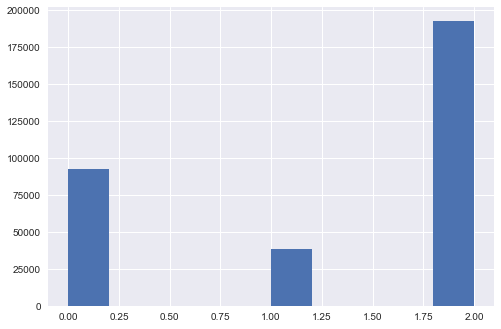

In [21]:
# clustering dataset
# determine k using elbow method
from sklearn.preprocessing import LabelEncoder
from sklearn.cluster import KMeans
from sklearn import metrics
from scipy.spatial.distance import cdist
import numpy as np
import matplotlib.pyplot as plt
 
X = df.drop('loadfactor_binned', axis=1)

# Encode the categorical features
for each in cat_var:
    le = LabelEncoder()
    le_fit = le.fit(X[each])
    le_transform = le.transform(df[each])
    X[each] = le_transform

# Based off the elbow chart, we are going to choose 3 clusters
from sklearn.preprocessing import normalize
from sklearn.model_selection import train_test_split
X_norm = normalize(X)

X_train, X_test = train_test_split( 
    X_norm,
    test_size=0.9,
    random_state=42)

km = KMeans(n_clusters=3, init='k-means++')
km_fitrans = km.fit_transform(X_norm)
    
# Extract cluster assignments for each data point.
labels_1 = km.labels_
    
plt.hist(labels_1)
plt.show()

df['clusters'] = labels_1

In [22]:
df.columns

Index(['DEPARTURES_SCHEDULED', 'DEPARTURES_PERFORMED', 'PAYLOAD', 'SEATS',
       'PASSENGERS', 'FREIGHT', 'MAIL', 'DISTANCE', 'RAMP_TO_RAMP', 'AIR_TIME',
       'UNIQUE_CARRIER_ENTITY', 'REGION', 'CARRIER_NAME', 'CARRIER_GROUP',
       'CARRIER_GROUP_NEW', 'ORIGIN', 'ORIGIN_CITY_NAME', 'ORIGIN_STATE_NM',
       'DEST', 'DEST_CITY_NAME', 'DEST_STATE_NM', 'AIRCRAFT_GROUP',
       'AIRCRAFT_TYPE', 'AIRCRAFT_CONFIG', 'YEAR', 'QUARTER', 'MONTH',
       'DISTANCE_GROUP', 'CLASS', 'passenger_miles', 'seat_miles',
       'load_factor', 'per_cap', 'loadfactor_level', 'loadfactor_binned',
       'High', 'Low', 'Medium', 'clusters'],
      dtype='object')

In [23]:
# Lets look at how many rows and observations there are now
print('Number of Features: ', len(df.columns))
print('Number of Observations: ', len(df))

Number of Features:  39
Number of Observations:  323187


# Classifier Models--No PCA

KNN Classifier--Weighted

In [24]:
from sklearn import neighbors
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score

cat_var_ = ['UNIQUE_CARRIER_ENTITY', 'REGION', 'CARRIER_NAME', 'CARRIER_GROUP', 'CARRIER_GROUP_NEW', 
          'ORIGIN', 'ORIGIN_CITY_NAME', 'ORIGIN_STATE_NM', 'DEST', 'DEST_CITY_NAME', 'DEST_STATE_NM', 
          'AIRCRAFT_GROUP', 'AIRCRAFT_TYPE', 'AIRCRAFT_CONFIG', 'YEAR', 'QUARTER', 'MONTH', 'DISTANCE_GROUP', 
          'CLASS']

def knn_weighted(X, y, n, cvk):
    for each in cat_var_:
        le = LabelEncoder()
        le_fit = le.fit(X[each])
        le_transform = le.transform(df[each])
        X[each] = le_transform
    X = StandardScaler().fit_transform(X)
    offset = int(X.shape[0] * 0.9)
    X_train, y_train = X[:offset], y[:offset]
    X_test, y_test = X[offset:], y[offset:]
    knn = neighbors.KNeighborsClassifier(n_neighbors=n, weights='distance')
    fit = knn.fit(X_train, y_train)
    pred= knn.predict(X_test)
    score = knn.score(X_test, y_test)
    cm = confusion_matrix(y_test, pred)
    fig, ax = plt.subplots()
    im = ax.matshow(cm)
    for (i, j), z in np.ndenumerate(cm):
        ax.text(j, i, '{:0.1f}'.format(z), ha='center', va='center', 
                bbox=dict(boxstyle='round', facecolor='white', edgecolor='0.3'))
    plt.title('Confusion matrix')
    fig.colorbar(im)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()
    class_rep = classification_report(y_test, pred)
    print('\nClassification Report: \n', class_rep)
    print("Percent of CORRECTLY labeled points out of a total {} points : {}".format(
    len(y_test),
    (1 - (y_test != pred).sum() / len(y_test)) * 100))

In [26]:
X = df.drop(['loadfactor_level', 'loadfactor_binned', 'High', 'Low', 'Medium',
            'load_factor', 'per_cap', 'passenger_miles', 'seat_miles', 'PASSENGERS'], axis=1)
y = df['loadfactor_level']

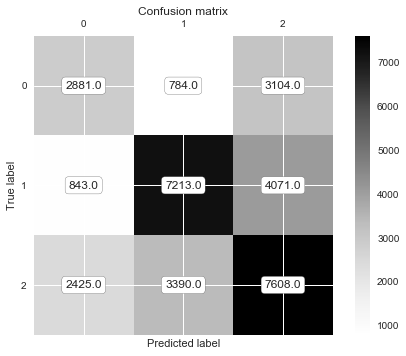


Classification Report: 
              precision    recall  f1-score   support

       High       0.47      0.43      0.45      6769
        Low       0.63      0.59      0.61     12127
     Medium       0.51      0.57      0.54     13423

avg / total       0.55      0.55      0.55     32319

Percent of CORRECTLY labeled points out of a total 32319 points : 54.77273430489804


In [27]:
knn_weighted(X, y, 10, 5)

In [28]:
from sklearn import ensemble

def ranfor_class(X, y, n_est, max_dep):
    offset = int(X.shape[0] * 0.9)
    X_train, y_train = X[:offset], y[:offset]
    X_test, y_test = X[offset:], y[offset:]
    rfc = ensemble.RandomForestClassifier(n_estimators=n_est, max_depth=max_dep)
    rfc_fit = rfc.fit(X_train, y_train)
    rfc_pred = rfc.predict(X_test)
    rfc_score = rfc.score(X_test, y_test)
    cm = confusion_matrix(y_test, rfc_pred)
    fig, ax = plt.subplots()
    im = ax.matshow(cm)
    for (i, j), z in np.ndenumerate(cm):
        ax.text(j, i, '{:0.1f}'.format(z), ha='center', va='center', 
                bbox=dict(boxstyle='round', facecolor='white', edgecolor='0.3'))
    plt.title('Confusion matrix')
    fig.colorbar(im)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()
    class_rep = classification_report(y_test, rfc_pred)
    print('\nClassification Report: \n', class_rep)
    print("Percent of CORRECTLY labeled points out of a total {} points : {}".format(
    len(y_test),
    (1 - (y_test != rfc_pred).sum() / len(y_test)) * 100))
    # Make importances relative to max importance
    feature_importance = rfc.feature_importances_
    feature_importance = 100 * (feature_importance / feature_importance.max())
    sorted_idx = np.argsort(feature_importance)
    pos = np.arange(sorted_idx.shape[0]) +  0.5
    plt.subplot(1, 2, 2)
    plt.barh(pos, feature_importance[sorted_idx], align='center')
    plt.yticks(pos, X.columns[sorted_idx])
    plt.xlabel('Relative importance')
    plt.ylabel('Variable importance')
    plt.show()

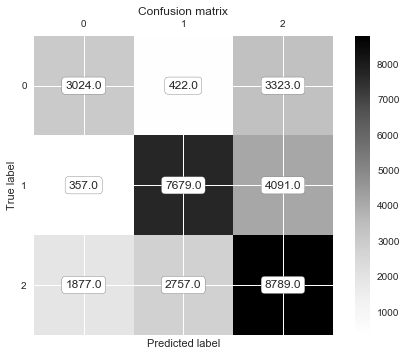


Classification Report: 
              precision    recall  f1-score   support

       High       0.58      0.45      0.50      6769
        Low       0.71      0.63      0.67     12127
     Medium       0.54      0.65      0.59     13423

avg / total       0.61      0.60      0.60     32319

Percent of CORRECTLY labeled points out of a total 32319 points : 60.31127200717844


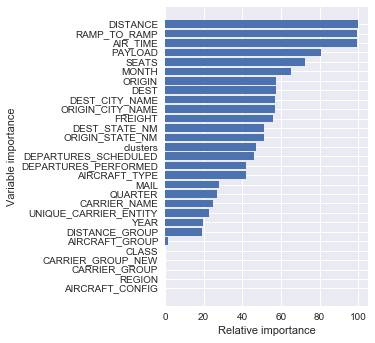

In [30]:
ranfor_class(X, y, 500, None)

In [31]:
def gb_class(X, y, los, n, md):
    offset = int(X.shape[0] * 0.9)
    X_train, y_train = X[:offset], y[:offset]
    X_test, y_test = X[offset:], y[offset:]
    gbc = ensemble.GradientBoostingClassifier(loss=los, n_estimators=n, max_depth=md)
    gbc_fit = gbc.fit(X_train, y_train)
    gbc_pred = gbc.predict(X_test)
    gbc_score = gbc.score(X_test, y_test)
    cm = confusion_matrix(y_test, gbc_pred)
    fig, ax = plt.subplots()
    im = ax.matshow(cm)
    for (i, j), z in np.ndenumerate(cm):
        ax.text(j, i, '{:0.1f}'.format(z), ha='center', va='center', 
                bbox=dict(boxstyle='round', facecolor='white', edgecolor='0.3'))
    plt.title('Confusion matrix')
    fig.colorbar(im)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()
    class_rep = classification_report(y_test, gbc_pred)
    print('\nClassification Report: \n', class_rep)
    print("Percent of CORRECTLY labeled points out of a total {} points : {}".format(
    len(y_test),
    (1 - (y_test != gbc_pred).sum() / len(y_test)) * 100
))
    
    # Make importances relative to max importance
    feature_importance = gbc.feature_importances_
    feature_importance = 100 * (feature_importance / feature_importance.max())
    sorted_idx = np.argsort(feature_importance)
    pos = np.arange(sorted_idx.shape[0]) +  0.5
    plt.subplot(1, 2, 2)
    plt.barh(pos, feature_importance[sorted_idx], align='center')
    plt.yticks(pos, X.columns[sorted_idx])
    plt.xlabel('Relative importance')
    plt.ylabel('Variable importance')
    plt.show()

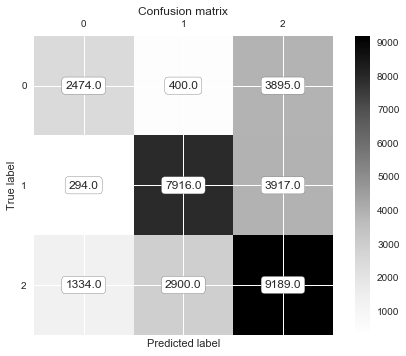


Classification Report: 
              precision    recall  f1-score   support

       High       0.60      0.37      0.46      6769
        Low       0.71      0.65      0.68     12127
     Medium       0.54      0.68      0.60     13423

avg / total       0.62      0.61      0.60     32319

Percent of CORRECTLY labeled points out of a total 32319 points : 60.580463504440104


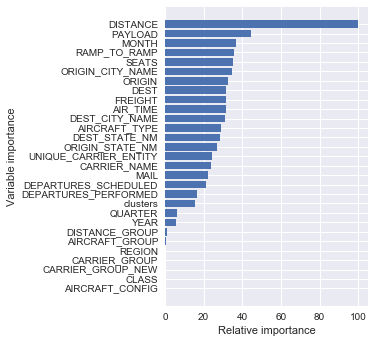

In [32]:
gb_class(X, y, 'deviance', 500, 5)